In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
import os
import numpy as np
import cv2
from tqdm import tqdm
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import itertools
import random
from sklearn.utils import shuffle
from keras import layers
from keras import models
from keras import backend as K

In [3]:
# Dataset link: https://drive.google.com/drive/folders/1RNOg9Au19eSA5xKd-Sx_GdAm6k1j-fCQ?usp=sharing
os.chdir('./drive/My Drive/signature_data_one_shot')

In [4]:
!ls

signature_forgery_one_shot.h5  test_data  train_data  validation_data


#Dataset

In [5]:
def get_data(dir):
    orig = []
    forg = []
    for name in tqdm(sorted(os.listdir(dir))):
        original = []
        forged = []
        for image_name in sorted(os.listdir(dir+'/'+name)):
            img = dir+'/'+name+'/'+image_name
            if 'forg' in name.lower():
                forged.append(img)
            else:
                original.append(img)
        
        if 'forg' in name.lower():
            forg.append(forged)
        else:
            orig.append(original)
    
    return orig, forg

In [6]:
train_orig, train_forg = get_data('train_data')
validation_orig, validation_forg = get_data('validation_data')
test_orig, test_forg = get_data('test_data')

100%|██████████| 14/14 [00:00<00:00, 2339.55it/s]


In [7]:
print(len(train_orig))
print(len(train_forg))
print(len(validation_orig))
print(len(validation_forg))
print(len(test_orig))
print(len(test_forg))

50
50
7
7
7
7


In [8]:
img = cv2.imread(train_orig[0][4], cv2.IMREAD_GRAYSCALE)

In [9]:
img.shape

(268, 650)

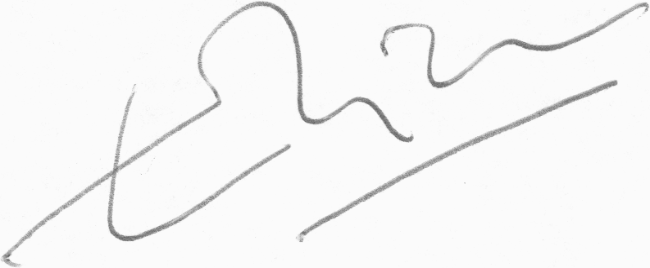

In [10]:
cv2_imshow(img)

#Creating the Model

In [11]:
def generate_batch(orig_groups, forg_groups, batch_size = 32):
    '''Function to generate a batch of data with batch_size number of data points
    Half of the data points will be Genuine-Genuine pairs and half will be Genuine-Forged pairs'''
    while True:
        orig_pairs = []
        forg_pairs = []
        gen_gen_labels = []
        gen_for_labels = []
        all_pairs = []
        all_labels = []
        
        # Here we create pairs of Genuine-Genuine image names and Genuine-Forged image names
        # For every person we have 12 genuine signatures, hence we have 
        # 12 choose 2 = 66 Genuine-Genuine image pairs for one person.
        # To make Genuine-Forged pairs, we pair every Genuine signature of a person
        # with 8 Forged signatures of the same person.
        # Thus we make 12 * 8 = 96 Genuine-Forged image pairs for one person.
        # In all we have 50 person's data in the training data.
        # Total no. of Genuine-Genuine pairs = 50 * 66 = 3300
        # Total number of Genuine-Forged pairs = 50 * 96 = 4800
        # Total no. of data points = 3300 + 4800 = 8100
        for orig, forg in zip(orig_groups, forg_groups):
            orig_pairs.extend(list(itertools.combinations(orig, 2)))
            for i in range(len(orig)):
                forg_pairs.extend(list(itertools.product(orig[i:i+1], forg)))
        
        # Label for Genuine-Genuine pairs is 1
        # Label for Genuine-Forged pairs is 0
        gen_gen_labels = [1]*len(orig_pairs)
        gen_for_labels = [0]*len(forg_pairs)
        
        # Concatenate all the pairs together along with their labels and shuffle them
        all_pairs = orig_pairs + forg_pairs
        all_labels = gen_gen_labels + gen_for_labels
        del orig_pairs, forg_pairs, gen_gen_labels, gen_for_labels
        all_pairs, all_labels = shuffle(all_pairs, all_labels)
            
        k = 0
        pairs=[np.zeros((batch_size, 268, 650, 1)) for i in range(2)]
        targets=np.zeros((batch_size,))
        for ix, pair in enumerate(all_pairs):
            img1 = cv2.imread(pair[0], cv2.IMREAD_GRAYSCALE)
            img2 = cv2.imread(pair[1], cv2.IMREAD_GRAYSCALE)
            img1 = np.array(img1, dtype = np.float64)
            img2 = np.array(img2, dtype = np.float64)
            img1 /= 255
            img2 /= 255
            img1 = img1[..., np.newaxis]
            img2 = img2[..., np.newaxis]
            pairs[0][k, :, :, :] = img1
            pairs[1][k, :, :, :] = img2
            targets[k] = all_labels[ix]
            k += 1
            if k == batch_size:
                yield pairs, targets
                k = 0
                pairs=[np.zeros((batch_size, 268, 650, 1)) for i in range(2)]
                targets=np.zeros((batch_size,))

In [12]:
def euclidean_distance(vects):
    '''Compute Euclidean Distance between two vectors'''
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))

In [13]:
def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [14]:
def create_base_network_signet(input_shape):
    '''Base Siamese Network'''
    
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape,padding='same'))
    model.add(layers.MaxPooling2D((2, 2),padding='same'))
    model.add(layers.Conv2D(64, (3, 3), activation='relu',padding='same'))
    model.add(layers.MaxPooling2D((2, 2),padding='same'))
    model.add(layers.Conv2D(64, (3, 3), activation='relu',padding='same'))
    model.add(layers.MaxPooling2D((2, 2),padding='same'))
    model.add(layers.Flatten())
    model.add(layers.Dense(1024, activation='relu'))
    model.add(layers.Dense(128, activation='relu'))

    return model

In [15]:
input_shape=(268, 650, 1)
base_network = create_base_network_signet(input_shape)

input_a = models.Input(shape=(input_shape))
input_b = models.Input(shape=(input_shape))

processed_a = base_network(input_a)
processed_b = base_network(input_b)

distance = layers.Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([processed_a, processed_b])
prediction = layers.Dense(1,activation='sigmoid')(distance)

model = models.Model(inputs=[input_a, input_b], outputs=prediction)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 268, 650, 1) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 268, 650, 1) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 128)          182902336   input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0           sequential[0][0]             

In [16]:
model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['accuracy'])

#Training the model

In [17]:
num_train_samples = 66*50 + 96*50
num_val_samples = num_test_samples = 66*7 + 96*7
num_train_samples, num_val_samples, num_test_samples

(8100, 1134, 1134)

In [18]:
batch_size=64
history = model.fit(generate_batch(train_orig, train_forg, batch_size),
                   steps_per_epoch = num_train_samples//batch_size,
                   epochs = 4,
                   validation_data = generate_batch(validation_orig, validation_forg, batch_size),
                   validation_steps = num_val_samples//batch_size)

Epoch 1/4
126/126 [==============================] - 106s 803ms/step - loss: 0.4107 - accuracy: 0.7002 - val_loss: 0.2635 - val_accuracy: 1.0000
Epoch 2/4
126/126 [==============================] - 100s 798ms/step - loss: 0.2643 - accuracy: 0.9896 - val_loss: 0.2486 - val_accuracy: 1.0000
Epoch 3/4
126/126 [==============================] - 100s 797ms/step - loss: 0.2278 - accuracy: 0.9994 - val_loss: 0.2191 - val_accuracy: 1.0000
Epoch 4/4
126/126 [==============================] - 100s 796ms/step - loss: 0.2064 - accuracy: 0.9988 - val_loss: 0.2063 - val_accuracy: 1.0000


#Plotting results

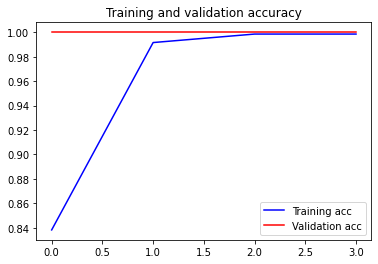

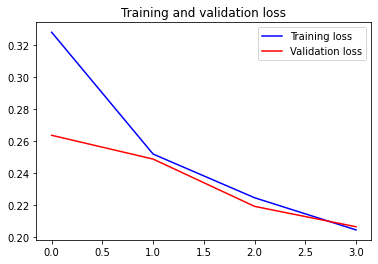

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

#Checking accuracy of Test set

In [20]:
test_loss, test_acc = model.evaluate(generate_batch(test_orig, test_forg, 1), steps=num_test_samples)
test_acc

1134/1134 [==============================] - 57s 50ms/step - loss: 0.2060 - accuracy: 0.9894


0.9894179701805115

#Saving the Model

In [21]:
model.save('signature_forgery_one_shot.h5')